In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib

tf.enable_eager_execution()

In [2]:
from tensorflow.keras.applications import MobileNet, Xception, ResNet50

In [3]:
img_size = 224  ## MobileNet, ResNet50
#img_size = 299 ## xception
conv_base = MobileNet(weights='imagenet', include_top=True,
                     input_shape=(img_size, img_size, 3))
#conv_base = Xception(weights='imagenet', include_top=True,
#                     input_shape=(img_size, img_size, 3))
#conv_base = ResNet50(weights='imagenet', include_top=True,
#                 input_shape=(img_size, img_size, 3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
conv_base.trainable = False

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [6]:
target_layer = conv_base.get_layer(name='conv_pw_13_relu').output

In [7]:
fmap_fn = keras.backend.function([conv_base.input], [target_layer])

In [8]:
from PIL import Image

#currimg = Image.open("data/boat.jpg")
currimg = Image.open("data/dog3.jpg")
currimg = currimg.resize((img_size, img_size))
image = np.asarray(currimg)/255. ## MobileNet, Xception
#image = np.asarray(currimg)  ## ResNet50
image = np.reshape(image, (-1, img_size, img_size, 3))
image.shape

(1, 224, 224, 3)

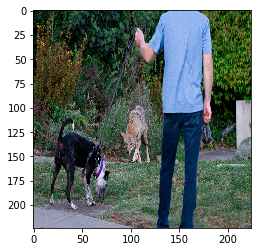

In [9]:
plt.imshow(image[0])
plt.show()

In [10]:
fmap = fmap_fn([image])

In [11]:
fmap = np.reshape(np.array(fmap), (7,7,1024))

In [12]:
prediction = np.argmax(conv_base.predict(image), -1)

In [13]:
prediction[0]

164

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[prediction+1])

['bluetick']


In [15]:
weights = np.reshape(conv_base.get_layer(name='conv_preds').get_weights()[0], (1024, 1000))
weights_cam = weights[:,prediction[0]]

In [16]:
camsum = np.zeros((7,7))
for i in range(1024):
    camsum = camsum + weights_cam[i]*fmap[:,:,i]
camsum = camsum / 1024.

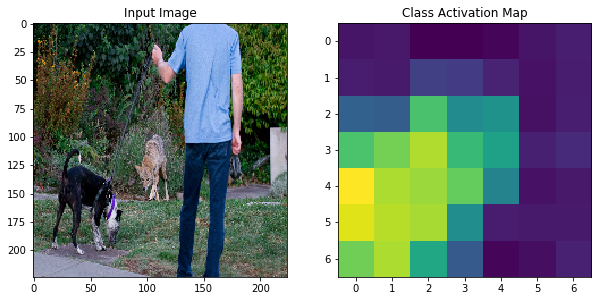

In [17]:
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(image[0])
ax1.set_title("Input Image")
ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(camsum)
ax2.set_title("Class Activation Map")
plt.show()